# Simulation script 

In [1]:
import sys
import os
import shutil
sys.path.insert(0, 'icenumerics/')

import pandas as pd
import numpy as np
import scipy.spatial as spa
import matplotlib.pyplot as plt
import matplotlib as mpl

import icenumerics as ice
from icenumerics.geometry import ordering 
import csv as csv
import time
import string as st
from multiprocessing import Pool

import copy as cp

ureg = ice.ureg

idx = pd.IndexSlice

import tqdm.auto as tqdm

%reload_ext autoreload
%autoreload 2

In [2]:
directory = "/home/carolina/Output_Sim_Summer_2020"
directory_DataFrame = "/home/carolina/DataFrames_Summer_2020"

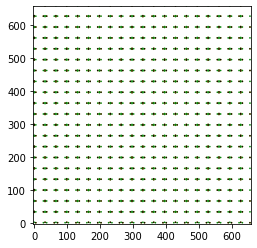

In [20]:
# def do_everything(exp_entry):
for i in range(0,1):
#     e = exp_entry[1].e 
#     l = exp_entry[1].l
    e = 1
    l = 20 
    
    
    
    # <To change the seed of the thermal noise>
    
    np.random.seed()
    
    # <Introduce the parameters for the simulation>

    lattice_constant = 33*ureg.um
    lattice_size = [l,l]
    sp = ice.spins()
    sp.create_lattice("square",[l,l],lattice_constant=33*ureg.um, border="periodic")

    particle1 = ice.particle(radius = 1*ureg.um,
             susceptibility = 0.5,
             diffusion = 0.2188*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

    particle2 = ice.particle(radius = 1*ureg.um,
             susceptibility = 0.0675151,
             diffusion = 0.2188*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

    trap_short = ice.trap(trap_sep = 23*ureg.um,
                   height = 0.5*ureg.pN*ureg.nm,
                   stiffness = 6e-4*ureg.pN/ureg.nm)

    trap_long = ice.trap(trap_sep = 30.3558*ureg.um,
                   height = 0.5*ureg.pN*ureg.nm,
                   stiffness = 6e-4*ureg.pN/ureg.nm)



    traps = []
    particles = []

    for s in sp:

        if s.direction[1] == 0:
            # Horizontal traps
            traps.append(trap_short) 
            particles.append(particle1)
            pass

        else: 
            # Vertical traps
            traps.append(trap_long) 
            particles.append(particle2)
    
    # < Loop to change the default value of s.center from e-19 to 0>
    
    for s in sp:
        if s.center[0] < 16*ureg.um:
            s.center[0] = 0.*ureg.um
            
    lattice = 33
            
    # <First we will change the horizontal traps>
    
    for s in sp:
    
        for i in range(0,l):
            # For the traps in Even positions.
            if i % 2 == 0:
                for j in range(0,l):
                    if j % 2 == 0:
                        if all(s.center == [lattice/2+i*lattice,j*lattice,0.]*ureg.um) :
                            s.direction =[-33,0.,0.]*ureg.um

            #For traps in Odd positions.
            else:
                for j in range(0,l):
                    if j % 2 == 0:
                        pass
                    else:
                        if all(s.center == [lattice/2+i*lattice,j*lattice,0.]*ureg.um) :
                            s.direction =[-33,0.,0.]*ureg.um
    
    
    # <And now the vertical ones>

    for s in sp:
    
        for i in range(0,l):
            if i % 2 == 0:
                for j in range(0,l):
                    if j % 2 == 0:
                        pass
                    else:
                        if all(s.center == [i*lattice,lattice/2+j*lattice,0.]*ureg.um) :
                            s.direction = [0.,-33,0.]*ureg.um
            else:
                for j in range(0,l):
                    if j % 2 == 0:
                        if all(s.center == [i*lattice,lattice/2+j*lattice,0.]*ureg.um) :
                            s.direction = [0.,-33,0.]*ureg.um
                            
    col = ice.colloidal_ice(sp, particles, traps , height_spread = 0 , susceptibility_spread = 0)
    
    # <Make the system periodic>
    
    col.region[:,:2]=(np.array([np.array([0,0]),lattice_size])-0.1)*(lattice_constant)
    col.region[:,2] = np.array([-.11,.11])*ureg.um
    
    # <Introduce the simulation parameters>
    
    world = ice.world(
        field = 70*ureg.mT,
        temperature = 300*ureg.K,
        dipole_cutoff = 200*ureg.um,
        boundaries = ["p", "p", "p"])

    total_time = 2000*ureg.s
    col.simulation(world,
                 name = "Bidisperse_Type3GS_l%u_exp%u"%(l,e),
                 include_timestamp = False,
                 targetdir = directory,
                 framerate = 1*ureg.Hz,
                 timestep = 10*ureg.ms,
                 run_time = total_time,
                 output = ["x","y","z","mux","muy","muz"])

    col.sim.field.fieldz = "v_Bmag"
    col.run_simulation()
    col.display()
    # <Load simulation and compute vertices dataframes>
    
    col.load_simulation(slice(0,None,15))
    
    v = ice.vertices()
    frames = col.trj.index.get_level_values("frame").unique()

    v_df = []

    for f in tqdm.tqdm(frames[::1]):
        col.set_state_from_frame(f)
        v = v.colloids_to_vertices(col)

        v_df.append(v.DataFrame())

    v_df = pd.concat(v_df, keys=frames[::1], names = ["frame"])
    v_df.tail()
    # <Save the dataframe and create index of the runned simulation>
    
    v_df.to_csv(os.path.join(directory_DataFrame,"Bidisperse_Type3GS_l%u_exp%u"%(l,e)+".dat"), sep='\t')
    
    name = os.path.split(col.sim.base_name)[1]
    with open(os.path.join(directory,"index_Bidisperse_Type3GS.dat"),'a',newline='') as file:
        writer = csv.writer(file,delimiter='\t')
        writer.writerow([name, l, e])

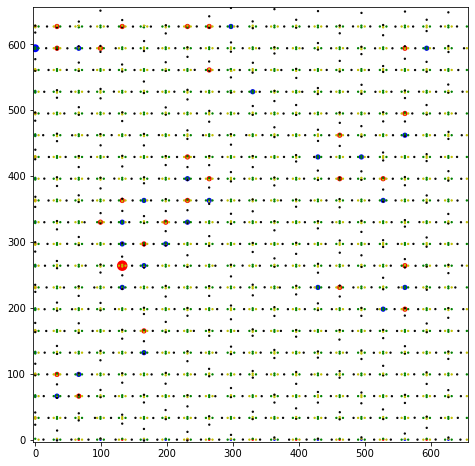

In [21]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))



v = v.colloids_to_vertices(col)
v.display(ax1)
col.display(ax1)


In [16]:
v_df.tail(26)

Coordination  Charge       DipoleX  DipoleY  LocationX  LocationY
frame id                                                                   
132   22             4       2 -2.000000e+00      0.0      132.0       99.0
      23             4       0  6.123234e-17      0.0      132.0       66.0
133   0              3       1 -2.000000e+00     -1.0       99.0        0.0
      1              3      -1  0.000000e+00     -1.0       33.0        0.0
      2              3       1 -1.000000e+00     -2.0        0.0       99.0
      3              4       0  2.000000e+00      2.0       33.0      132.0
      4              3      -1  1.000000e+00     -2.0        0.0      132.0
      5              4       0  2.000000e+00     -2.0       66.0      132.0
      6              3       1  1.000000e+00      0.0        0.0       33.0
      7              4       0  6.123234e-17      0.0       66.0       99.0
      8              4       0  1.110223e-16      0.0       99.0       33.0
      9              3      -3  6.123234e-17      1.0      132.0        0.0
      10             4       2 -2.000000e+00      0.0      132.0       33.0
      11             4       0  1.110223e-16      0.0       99.0       66.0
      12             4       0  2.000000e+00     -2.0      132.0      132.0
      13             4       2  2.000000e+00      0.0       99.0      132.0
      14             4       0  6.123234e-17      0.0       99.0       99.0
      15             3       1  6.123234e-17      1.0       66.0        0.0
      16             4       0  6.123234e-17      0.0       66.0       66.0
      17             4       0  1.110223e-16      0.0       66.0       33.0
      18             4       0  6.123234e-17      0.0       33.0       33.0
      19             4       0  6.123234e-17      0.0       33.0       66.0
      20             4      -2 -2.000000e+00      0.0       33.0       99.0
      21             3       1 -1.000000e+00     -2.0        0.0       66.0
      22             4       2 -2.000000e+00      0.0      132.0       99.0
      23             4       0  6.123234e-17      0.0      132.0       66.0

In [10]:
e =  np.arange(0,1)
l =  np.arange(6,7)
L, E = np.meshgrid(l,e)
experiments = pd.DataFrame({"e":E.flatten(),"l":L.flatten()})

In [11]:
# %%time
if __name__ ==  '__main__': 
    num_processors = 6
    p=Pool(processes = num_processors)
    
    ## Create index text file
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(directory,"index_Bidisperse.dat"),'w',newline='') as file:
        writer = csv.writer(file,delimiter='\t')
        writer.writerow(["filename", "l", "exp"])
        
    list(tqdm.tqdm(p.imap(do_everything, experiments.iterrows()), total=len(experiments)))

--- Logging error ---
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1029, in emit
    self.flush()
  File "/home/carolina/anaconda3/lib/python3.7/logging/__init__.py", line 1009, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carolina/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/carolina/anaconda3/lib/python3

  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 605, in notify_change
    self.send_state(key=name)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 489, in send_state
    self._send(msg, buffers=buffers)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py", line 737, in _send
    self.comm.send(data=msg, buffers=buffers)
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 123, in send
    data=data, metadata=metadata, buffers=buffers,
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel/comm/comm.py", line 71, in _publish_msg
    buffers=buffers,
  File "/home/carolina/anaconda3/lib/python3.7/site-packages/jupyter_client/session.py", line 716, in send
    msg
Message: 'WARNING: attempted to send message from fork\n%s'
Arguments: {'header': {'msg_id': '4a1dc2fb-e6b0337fd554974980190f6c', 'msg_type

Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/carolina/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/carolina/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/carolina/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carolina/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/carolina/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _boot

# Checking the vertices assignation

# Not parallel computation

In [3]:
directory = r"."

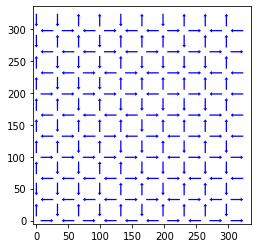

In [4]:
e = 1
l = 10

np.random.seed()

lattice_constant = 33*ureg.um
lattice_size = [l,l]
sp = ice.spins()
sp.create_lattice("square",[l,l],lattice_constant=33*ureg.um, border="periodic")
sp.order_spins(ordering.random_ordering)

sp.display()

New parameters in order to try to recover the full degeneracy.

In [5]:
particle1 = ice.particle(radius = 1*ureg.um,
         susceptibility = 0.5,
         diffusion = 0.2188*ureg.um**2/ureg.s,
         temperature = 300*ureg.K,
         density = 1000*ureg.kg/ureg.m**3)

particle2 = ice.particle(radius = 1*ureg.um,
         susceptibility = 0.0675151,
         diffusion = 0.2188*ureg.um**2/ureg.s,
         temperature = 300*ureg.K,
         density = 1000*ureg.kg/ureg.m**3)

trap_short = ice.trap(trap_sep = 23*ureg.um,
               height = 0.5*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

trap_long = ice.trap(trap_sep = 30.3558*ureg.um,
               height = 0.5*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)


traps = []
particles = []

for s in sp:

    if s.direction[1] == 0:
        # Horizontal traps
        traps.append(trap_short) 
        particles.append(particle1)
        pass

    else: 
        # Vertical traps
        traps.append(trap_long) 
        particles.append(particle2) 



First we will reset the 0 values

In [7]:
# Loop to change the default value of s.center from e-19 to 0.
## ONLY IF PERIODIC BORDER ARE USED ##

for s in sp:
#     print(s.center[0])
    if s.center[0] < 16*ureg.um:
        s.center[0] = 0.*ureg.um

In [8]:
lattice = 33

First we will change the horizontal traps

In [9]:
for s in sp:
    
    for i in range(0,l):
        # For the traps in Even positions.
        if i % 2 == 0:
            for j in range(0,l):
                if j % 2 == 0:
                    if all(s.center == [lattice/2+i*lattice,j*lattice,0.]*ureg.um) :
                        s.direction =[-33,0.,0.]*ureg.um
        
        #For traps in Odd positions.
        else:
            for j in range(0,l):
                if j % 2 == 0:
                    pass
                else:
                    if all(s.center == [lattice/2+i*lattice,j*lattice,0.]*ureg.um) :
                        s.direction =[-33,0.,0.]*ureg.um

And now the vertical ones.

In [10]:
for s in sp:
    
    for i in range(0,l):
        if i % 2 == 0:
            for j in range(0,l):
                if j % 2 == 0:
                    pass
                else:
                    if all(s.center == [i*lattice,lattice/2+j*lattice,0.]*ureg.um) :
                        s.direction = [0.,-33,0.]*ureg.um
        else:
            for j in range(0,l):
                if j % 2 == 0:
                    if all(s.center == [i*lattice,lattice/2+j*lattice,0.]*ureg.um) :
                        s.direction = [0.,-33,0.]*ureg.um
            

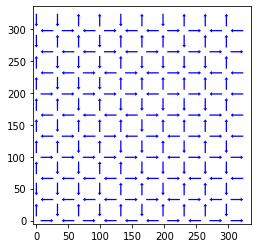

In [6]:
sp.display()

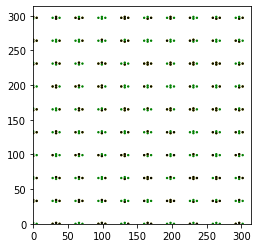

In [7]:
col = ice.colloidal_ice(sp, particles, traps , height_spread = 0 , susceptibility_spread = 0)
col.display()

In [11]:

col.calculate_energy(B = [0,0,30]*ureg.mT)



36785.646532596686 <Unit('nanometer * piconewton')>

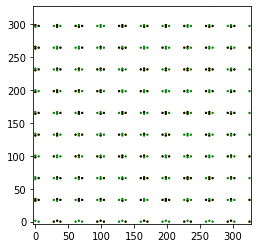

In [8]:
col.region[:,:2]=(np.array([np.array([0,0]),lattice_size])-0.1)*(lattice_constant)
col.region[:,2] = np.array([-.11,.11])*ureg.um

col.display()

In [9]:
world = ice.world(
    field = 200*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um,
    boundaries = ["p", "p", "p"])

total_time = 5800*ureg.s
col.simulation(world,
             name = "FullyDegeneracy_Type3_l%u_exp%u"%(l,e),
             include_timestamp = False,
             targetdir = directory,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])


# col.sim.field.fieldz = 50*ureg.mT   
#col.sim.field.fieldz = "v_Bmag"
col.sim.field.fieldz = "v_Bmag*time/%f"%total_time.to(ureg.us).magnitude

col.run_simulation()

In [13]:
200/0.035

5714.285714285714

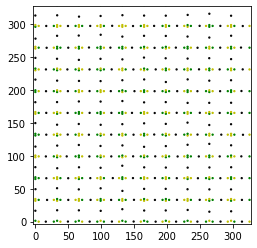

In [10]:
col.load_simulation()
col.display()

In [17]:
col.trj.head(500)


type             x           y    z  mux  muy           muz    t
frame id                                                                   
0     1       1  1.939710e-15   31.677900  0.0  0.0  0.0  0.000000e+00  0.0
      2       1  3.300000e+01    1.322100  0.0  0.0  0.0  0.000000e+00  0.0
      3       1  6.600000e+01   31.677900  0.0  0.0  0.0  0.000000e+00  0.0
      4       1  9.900000e+01    1.322100  0.0  0.0  0.0  0.000000e+00  0.0
      5       1  1.320000e+02   31.677900  0.0  0.0  0.0  0.000000e+00  0.0
...         ...           ...         ...  ...  ...  ...           ...  ...
1     96      1  1.650590e+02   -1.899410  0.0  0.0  0.0  2.595440e-08  1.0
      97      1  1.979920e+02  298.230011  0.0  0.0  0.0  2.595440e-08  1.0
      98      1  2.308640e+02   -1.465410  0.0  0.0  0.0  2.595440e-08  1.0
      99      1  2.640180e+02   -2.429290  0.0  0.0  0.0  2.595440e-08  1.0
      100     1  2.970160e+02   -1.446900  0.0  0.0  0.0  2.595440e-08  1.0

[500 rows x 8 columns]

In [18]:
col

In [34]:
499/99.8*20

100.0

# Visual pre analysis of the Simulation

In [19]:
v = ice.vertices()
v = v.colloids_to_vertices(col)

IndexError: index 200 is out of bounds for axis 0 with size 100

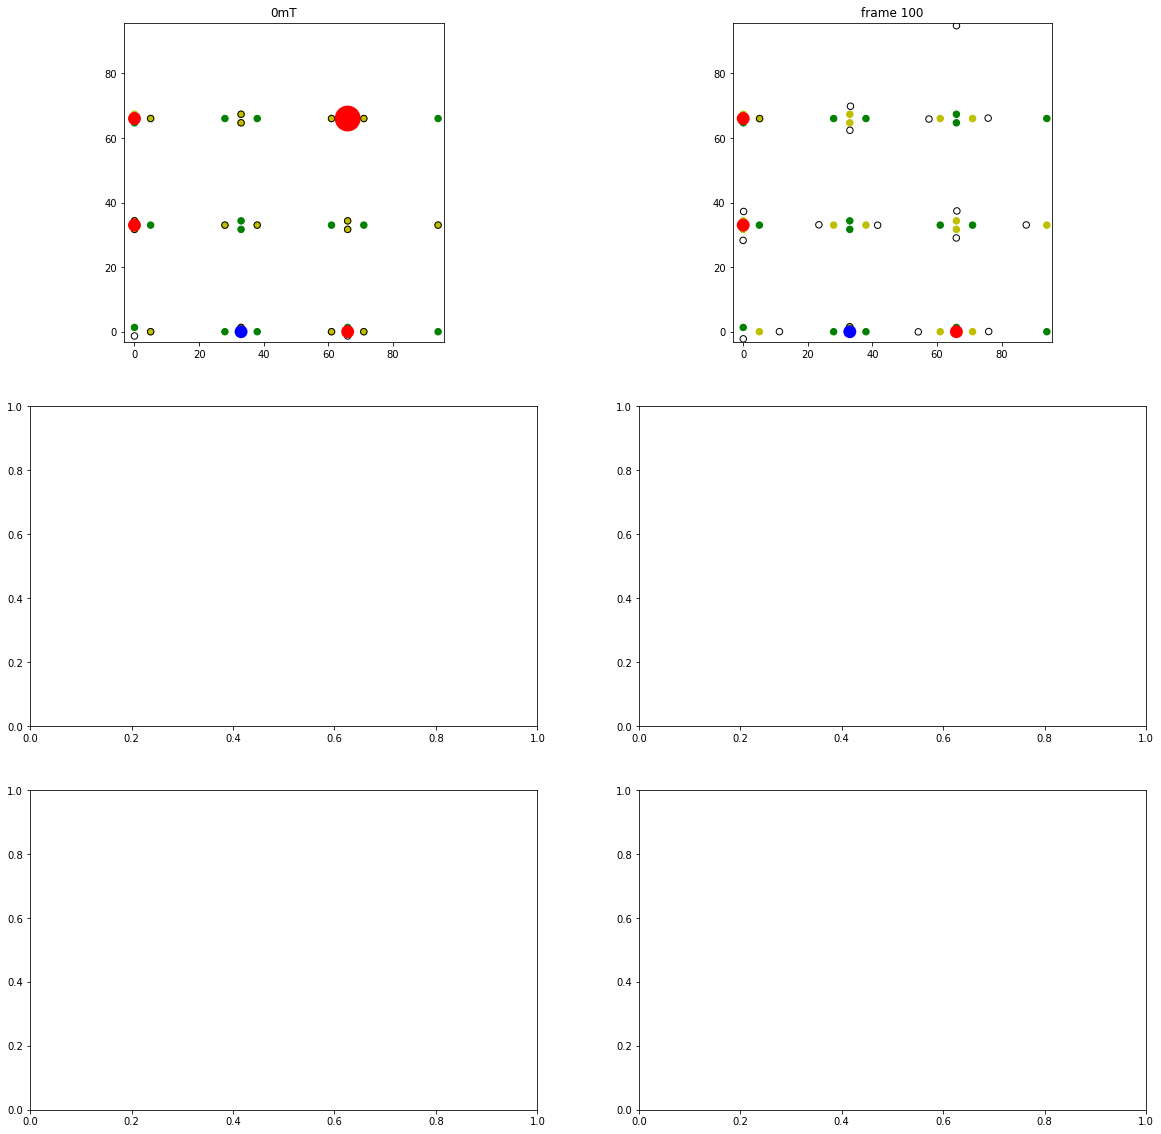

In [20]:

f, axes = plt.subplots(3,2,figsize = (20,20))
ax1, ax2, ax3, ax4, ax5,ax6 = axes.flatten()

col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)
ax1.set_title('0mT')
col.display(ax1)
v.display(ax1)
col.set_state_from_frame(1)
v = v.colloids_to_vertices(col)

ax2.set_title('frame 100')
col.display(ax2)
v.display(ax2)
col.set_state_from_frame(200)
v = v.colloids_to_vertices(col)

ax3.set_title('frame 600')
col.display(ax3)
v.display(ax3)
col.set_state_from_frame(300)

ax4.set_title('frame 700')
col.display(ax4)
col.set_state_from_frame(400)

ax5.set_title('frame 800')
col.display(ax5)
col.set_state_from_frame(1999)
v = v.colloids_to_vertices(col)

ax6.set_title('50mT')
v.display(ax6)
col.display(ax6)




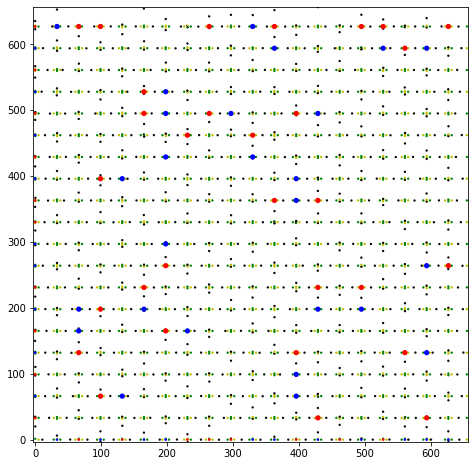

In [39]:
f, (ax1) = plt.subplots(1,1,figsize = (8,8))


col.set_state_from_frame(1999)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)

# Following the Energy value of the whole system

In [18]:
col.set_state_from_frame(100)
col.calculate_energy(B = [0,0,200]*ureg.mT).magnitude

39404.63322743968

In [18]:
col.trj

type             x         y    z           mux        muy  muz  \
frame id                                                                     
0     1       1  1.939710e-15   31.6779  0.0  0.000000e+00   0.000000  0.0   
      2       1  3.300000e+01    1.3221  0.0  0.000000e+00   0.000000  0.0   
      3       1  6.600000e+01   31.6779  0.0  0.000000e+00   0.000000  0.0   
      4       1  9.900000e+01    1.3221  0.0  0.000000e+00   0.000000  0.0   
      5       1  1.320000e+02   31.6779  0.0  0.000000e+00   0.000000  0.0   
...         ...           ...       ...  ...           ...        ...  ...   
5799  396     4  1.650000e+02  313.5000  0.0  1.858760e-15  30.355801  0.0   
      397     4  1.980000e+02  313.5000  0.0 -1.858760e-15 -30.355801 -0.0   
      398     4  2.310000e+02  313.5000  0.0  1.858760e-15  30.355801  0.0   
      399     4  2.640000e+02  313.5000  0.0  1.858760e-15  30.355801  0.0   
      400     4  2.970000e+02  313.5000  0.0  1.858760e-15  30.355801  0.0   

                t  
frame id           
0     1       0.0  
      2       0.0  
      3       0.0  
      4       0.0  
      5       0.0  
...           ...  
5799  396  5799.0  
      397  5799.0  
      398  5799.0  
      399  5799.0  
      400  5799.0  

[2320000 rows x 8 columns]

In [21]:
200/5800*1

0.034482758620689655

In [22]:
E = []
t = []
for i in range(0,5799):
    col.set_state_from_frame(i)
    E.append(col.calculate_energy(B = [0,0,200/5800*i]*ureg.mT).magnitude)
    # 5 fr/s
    #t.append(i/5)
    t.append(i)
    


The units of the energy are nanometer * piconewton

In [23]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 500

mpl.rcParams['font.family'] = 'serif'

# ax1.tick_params(axis='y', labelsize=30)    
  

# ax3.tick_params(axis='x', labelsize=30)

In [21]:

t[20],E[20]

(4.0, 39800.729218642584)

In [27]:
150/200*5800

4350.0

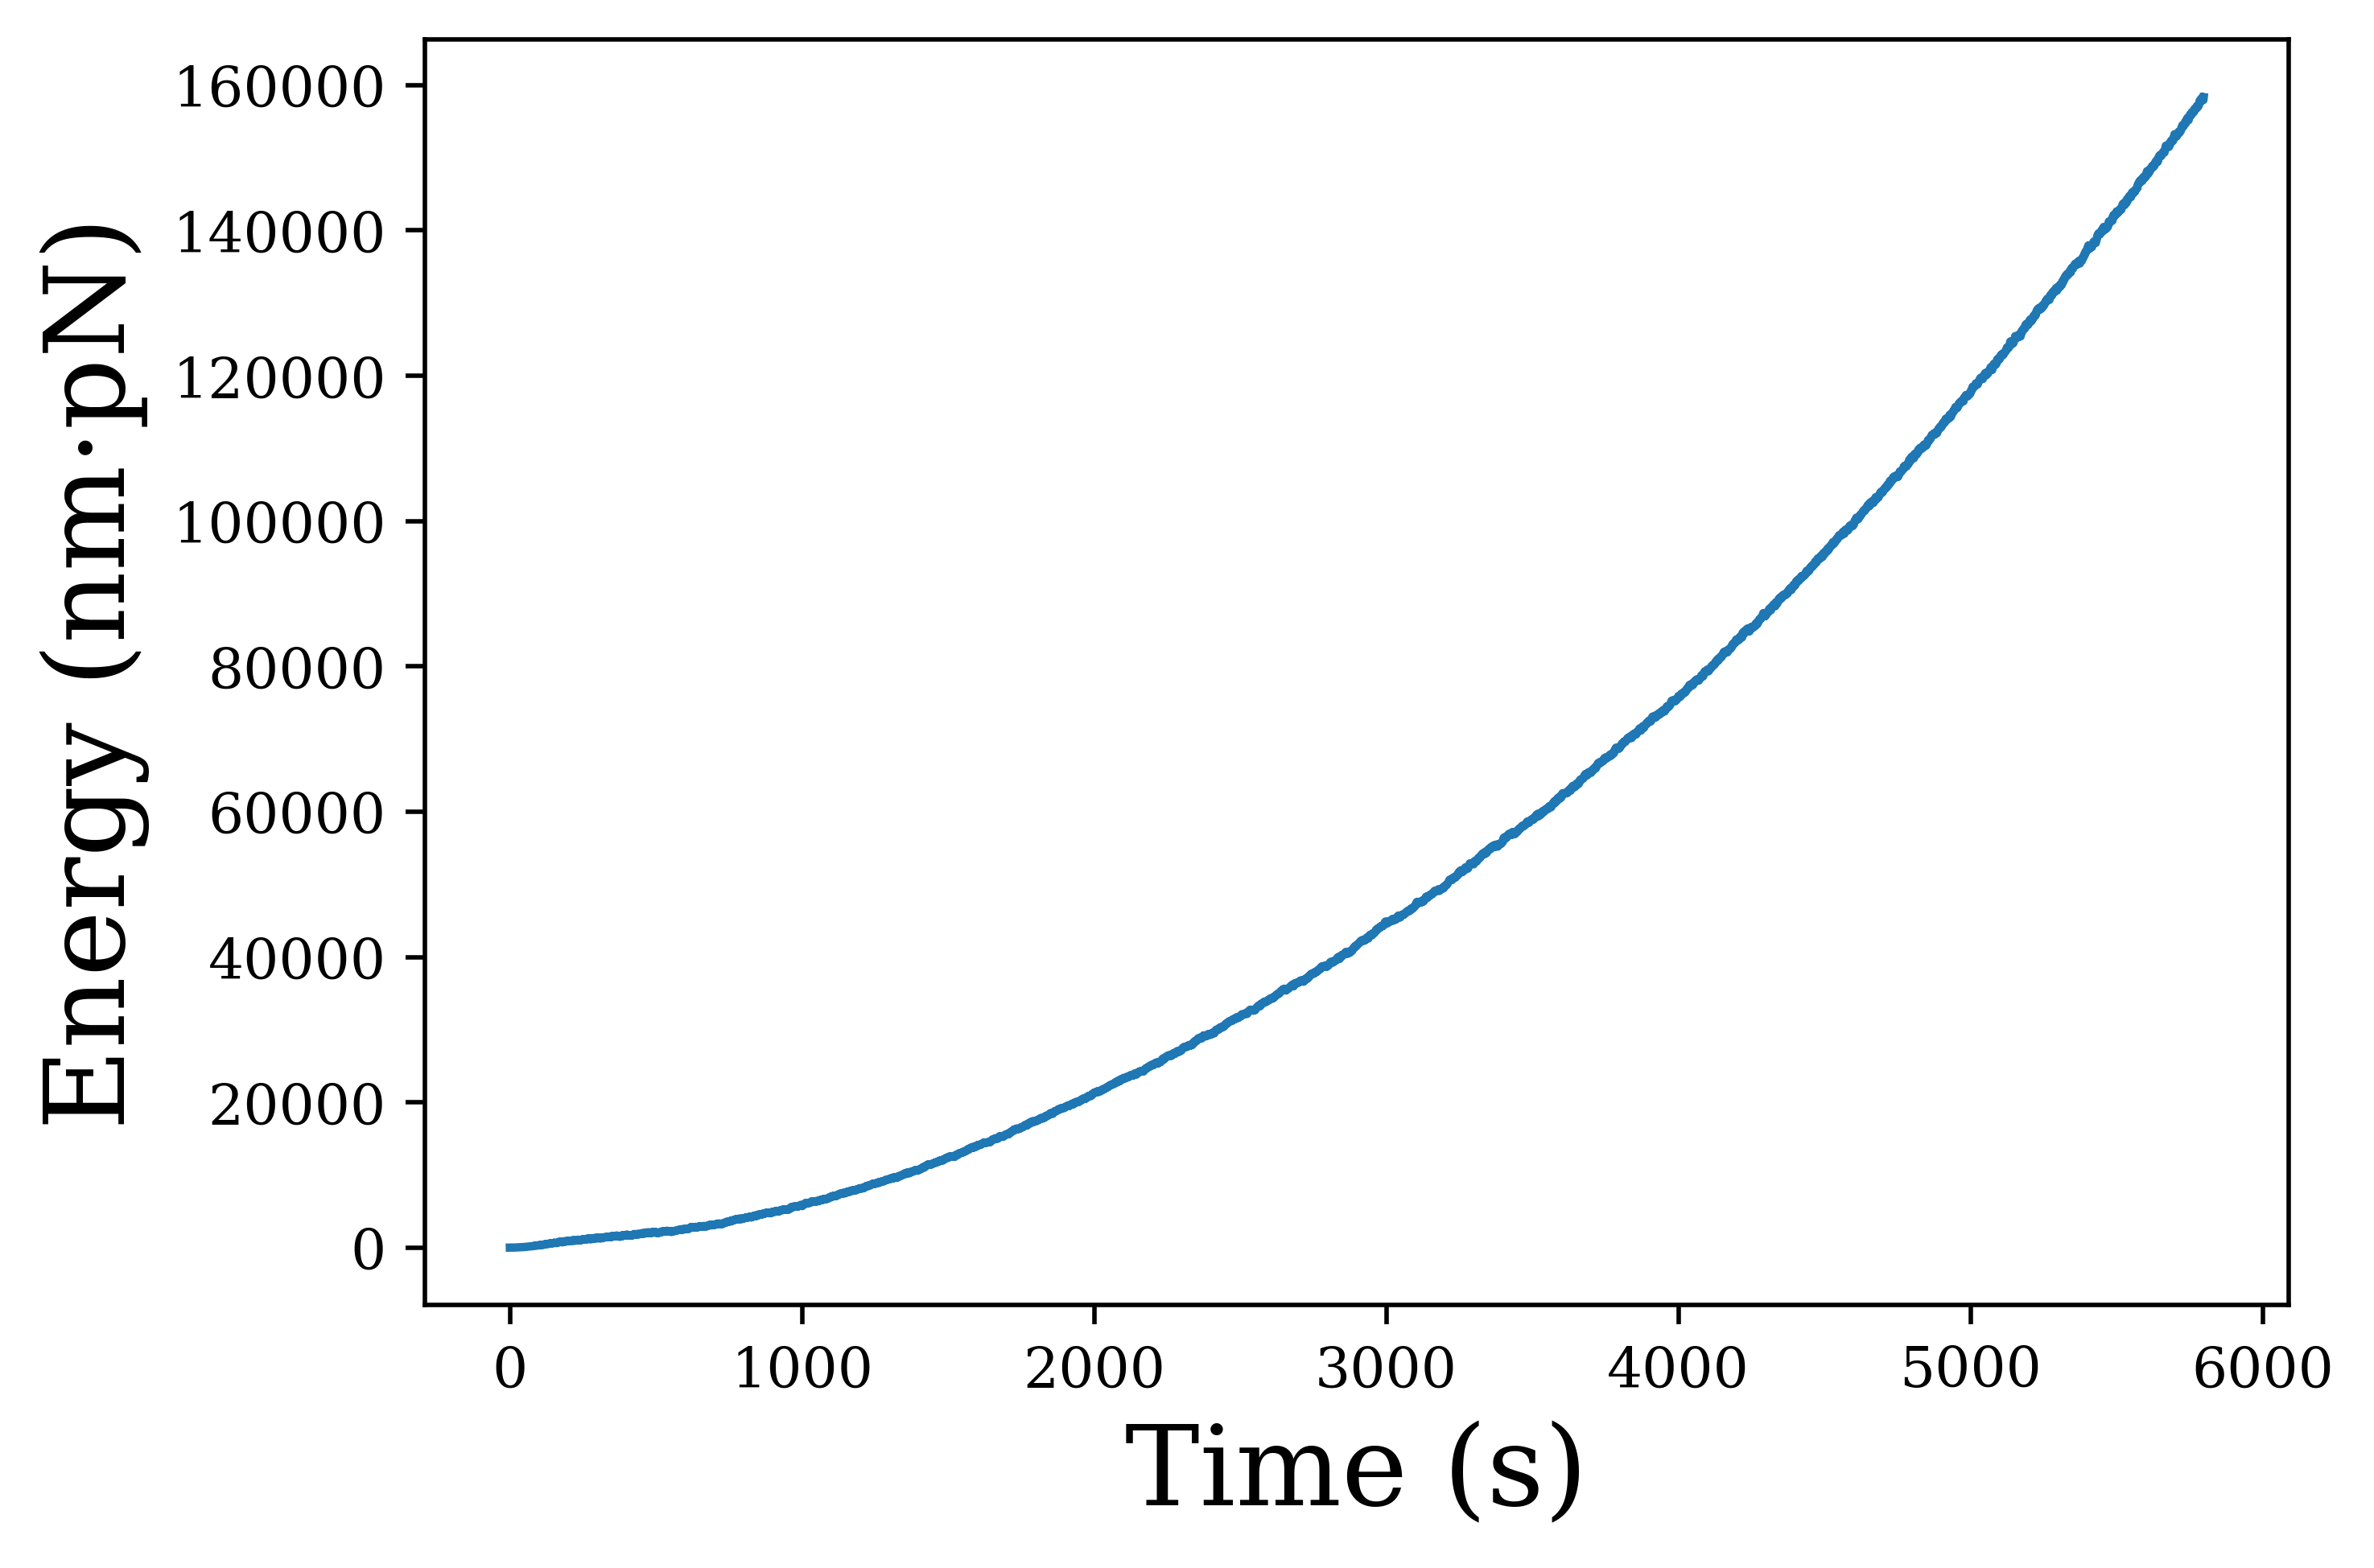

In [32]:
plt.plot(t,E)
plt.xlabel('Time (s)', size = 20)
plt.ylabel('Energy (nm·pN)', size = 20)
plt.tight_layout()
#plt.xlim(3000, 4350)
# plt.savefig('Evst_type3conf')